In [10]:
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import pickle
from sklearn.metrics import classification_report
from sklearn.datasets import make_circles, make_moons
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

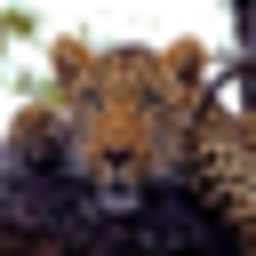

In [11]:
# Чтение тренировочной выборки (обучающих данных)
with open('cifar-100-python/train', 'rb') as f:
    data_train = pickle.load(f, encoding='latin1')

# Чтение тестовой выборки (тестовых данных)
with open('cifar-100-python/test', 'rb') as f:
    data_test = pickle.load(f, encoding='latin1')

# Здесь указать ваши классы по варианту!!!
# Переформируем выборку и оставляем только 3 указанных класса.
CLASSES = [73, 12, 42]

train_X = data_train['data'].reshape(-1, 3, 32, 32)
train_X = np.transpose(train_X, [0, 2, 3, 1]) # NCHW -> NHWC
train_y = np.array(data_train['fine_labels'])
mask = np.isin(train_y, CLASSES)
train_X = train_X[mask].copy()
train_y = train_y[mask].copy()
train_y = np.unique(train_y, return_inverse=1)[1]
del data_train

test_X = data_test['data'].reshape(-1, 3, 32, 32)
test_X = np.transpose(test_X, [0, 2, 3, 1])
test_y = np.array(data_test['fine_labels'])
mask = np.isin(test_y, CLASSES)
test_X = test_X[mask].copy()
test_y = test_y[mask].copy()
test_y = np.unique(test_y, return_inverse=1)[1]
del data_test
Image.fromarray(train_X[50]).resize((256,256))

In [12]:
# Указываем размер батча 
batch_size = 100

dataloader = {}
for (X, y), part in zip([(train_X, train_y), (test_X, test_y)],
                        ['train', 'test']):
    tensor_x = torch.Tensor(X)
    tensor_y = F.one_hot(torch.Tensor(y).to(torch.int64),
                                     num_classes=len(CLASSES))/1.
    dataset = TensorDataset(tensor_x, tensor_y) # создание объекта датасета
    dataloader[part] = DataLoader(dataset, batch_size=batch_size, shuffle=True) # создание экземпляра класса DataLoader
dataloader

{'train': <torch.utils.data.dataloader.DataLoader at 0x17f316460>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x17f316730>}

In [13]:
class Normalize(nn.Module):
    def __init__(self, mean, std):
        super(Normalize, self).__init__()
        self.mean = torch.tensor(mean)
        self.std = torch.tensor(std)

    def forward(self, input):
        x = input / 255.0
        x = x - self.mean
        x = x / self.std
        return torch.flatten(x, start_dim=1) # nhwc -> nm

# Создадим простой многослойный перцептрон с одним скрытым слоем и функцией нелинейности.
# Количество скрытых слоев можно изменять.
class Cifar100_MLP(nn.Module):
    def __init__(self, hidden_size=32, classes=100):
        super(Cifar100_MLP, self).__init__()
        # https://blog.jovian.ai/image-classification-of-cifar100-dataset-using-pytorch-8b7145242df1
        self.norm = Normalize([0.5074,0.4867,0.4411],[0.2011,0.1987,0.2025])
        self.seq = nn.Sequential(
            nn.Linear(32*32*3, hidden_size), 
            nn.ReLU(), # активационная функция
            nn.Linear(hidden_size, classes),
        )

    def forward(self, input):
        x = self.norm(input)
        return self.seq(x)

HIDDEN_SIZE = 10
model = Cifar100_MLP(hidden_size=HIDDEN_SIZE, classes=len(CLASSES))
model

Cifar100_MLP(
  (norm): Normalize()
  (seq): Sequential(
    (0): Linear(in_features=3072, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=3, bias=True)
  )
)

In [14]:
# Функция потерь
criterion = nn.CrossEntropyLoss()
# Оптимизатор
# lr - шаг обучения. Данный параметр можно изменять.
optimizer = optim.SGD(model.parameters(), lr=0.005)

In [15]:
# Укажем количество эпох. 
# Увеличение количества эпох приводит к увеличению времени работы программы.
# Чем больше эпох мы обучаем, тем точнее обучается модель, но есть риск наступления переобучения.

EPOCHS = 250
steps_per_epoch = len(dataloader['train'])
steps_per_epoch_val = len(dataloader['test'])
for epoch in range(EPOCHS):  # проход по набору данных несколько раз
    running_loss = 0.0
    model.train()
    for i, batch in enumerate(dataloader['train'], 0):
        # получение одного минибатча; batch это двуэлементный список из [inputs, labels]
        inputs, labels = batch

        # очищение прошлых градиентов с прошлой итерации
        optimizer.zero_grad()

        # прямой + обратный проходы + оптимизация
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        #loss = F.cross_entropy(outputs, labels)
        loss.backward()

        #Для обновления параметров нейронной сети используется метод step, применённый к экземпляру класса оптимизатора.
        optimizer.step()

        # для подсчёта статистик
        running_loss += loss.item()
    print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / steps_per_epoch:.3f}')
    running_loss = 0.0

    #Для перевода модели в состояние проверки необходимо вызвать метод eval. После чего модель готова для проверки.
    model.eval()

    with torch.no_grad(): # отключение автоматического дифференцирования
        for i, data in enumerate(dataloader['test'], 0):
            inputs, labels = data

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
    print(f'[{epoch + 1}, {i + 1:5d}] val loss: {running_loss / steps_per_epoch_val:.3f}')
print('Обучение закончено')

[1,    15] loss: 0.782
[1,     3] val loss: 0.732
[2,    15] loss: 0.630
[2,     3] val loss: 0.697
[3,    15] loss: 0.589
[3,     3] val loss: 0.689
[4,    15] loss: 0.567
[4,     3] val loss: 0.671
[5,    15] loss: 0.544
[5,     3] val loss: 0.666
[6,    15] loss: 0.525
[6,     3] val loss: 0.659
[7,    15] loss: 0.510
[7,     3] val loss: 0.648
[8,    15] loss: 0.497
[8,     3] val loss: 0.638
[9,    15] loss: 0.484
[9,     3] val loss: 0.647
[10,    15] loss: 0.477
[10,     3] val loss: 0.633
[11,    15] loss: 0.467
[11,     3] val loss: 0.632
[12,    15] loss: 0.459
[12,     3] val loss: 0.629
[13,    15] loss: 0.450
[13,     3] val loss: 0.619
[14,    15] loss: 0.441
[14,     3] val loss: 0.617
[15,    15] loss: 0.436
[15,     3] val loss: 0.620
[16,    15] loss: 0.427
[16,     3] val loss: 0.617
[17,    15] loss: 0.422
[17,     3] val loss: 0.616
[18,    15] loss: 0.415
[18,     3] val loss: 0.608
[19,    15] loss: 0.410
[19,     3] val loss: 0.608
[20,    15] loss: 0.403
[20,  

In [16]:
for part in ['train', 'test']:
    y_pred = []
    y_true = []
    with torch.no_grad(): # отключение автоматического дифференцирования
        for i, data in enumerate(dataloader[part], 0):
            inputs, labels = data

            outputs = model(inputs).detach().numpy()
            y_pred.append(outputs)
            y_true.append(labels.numpy())
        y_true = np.concatenate(y_true)
        y_pred = np.concatenate(y_pred)
        
        # Выведем отчет о точности обучения модели.
        # На тестовых данных модель может обучиться до 100%. Результ, который показывается на тренировочной выборке, хуже.
        
        # Выведем метрики ранжирования для тестовой и обучающей выборки.
        print(part)

        # Значения выводятся с точность 4 знака после запятой.

        print(classification_report(y_true.argmax(axis=-1), y_pred.argmax(axis=-1),
                                    digits=4, target_names=list(map(str, CLASSES))))
        print('-'*50)

train
              precision    recall  f1-score   support

          73     0.9901    0.9960    0.9930       500
          12     0.9921    1.0000    0.9960       500
          42     0.9980    0.9840    0.9909       500

    accuracy                         0.9933      1500
   macro avg     0.9934    0.9933    0.9933      1500
weighted avg     0.9934    0.9933    0.9933      1500

--------------------------------------------------
test
              precision    recall  f1-score   support

          73     0.7979    0.7500    0.7732       100
          12     0.8020    0.8100    0.8060       100
          42     0.8095    0.8500    0.8293       100

    accuracy                         0.8033       300
   macro avg     0.8031    0.8033    0.8028       300
weighted avg     0.8031    0.8033    0.8028       300

--------------------------------------------------


In [17]:
# ВТОРОЙ СПОСОБ: сохранение всей архитектуры
PATH2 = 'cifar_lnn.pt'
torch.save(model, PATH2)
# загрузка
new_model_2 = torch.load(PATH2)
new_model_2.eval()

Cifar100_MLP(
  (norm): Normalize()
  (seq): Sequential(
    (0): Linear(in_features=3072, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=3, bias=True)
  )
)

In [18]:
# входной тензор для модели
x = torch.randn(1, 32, 32, 3, requires_grad=True).to('cpu')
torch_out = model(x)

# экспорт модели
torch.onnx.export(model,               # модель
                  x,                   # входной тензор (или кортеж нескольких тензоров)
                  "cifar100_LNN.onnx", # куда сохранить (либо путь к файлу либо fileObject)
                  export_params=True,  # сохраняет веса обученных параметров внутри файла модели
                  opset_version=9,     # версия ONNX
                  do_constant_folding=True,  # следует ли выполнять укорачивание констант для оптимизации
                  input_names = ['input'],   # имя входного слоя
                  output_names = ['output'],  # имя выходного слоя
                  dynamic_axes={'input' : {0 : 'batch_size'},    # динамичные оси, в данном случае только размер пакета
                                'output' : {0 : 'batch_size'}})